# darepo

This package is designed to aid in the efficient analysis of large simulations, such as cosmological (hydrodynamical) simulations of large-scale structure.

It uses the [dask](https://dask.org/) library to perform computations, which has two key advantages:
* (i) very large datasets which cannot normally fit into memory can be analyzed, and
* (ii) calculations can be automatically distributed onto parallel 'workers', across one or more (MPI) nodes, to speed them up.

# [0] Select a simulation and snapshot

The first step is to chose an existing snapshot of a simulation. To start, we will intentionally select the $z=0$ output of TNG50-4, which is the lowest resolution version of TNG50. This means that the size of data in the snapshot is small and easy to work with.

In [4]:
from darepo.interfaces.arepo import ArepoSnapshot
path = "../../sims.TNG/TNG50-4/output/snapdir_099/"
snap = ArepoSnapshot(path)

# [1] Get familiar with a snapshot

## Header metadata
The snapshot contains a dictionary for the AREPO simulation header, config and parameters in its namespace. We can inspect the header:

In [25]:
snap.header

{'BoxSize': 35000.0,
 'Composition_vector_length': 0,
 'Flag_Cooling': 1,
 'Flag_DoublePrecision': 0,
 'Flag_Feedback': 1,
 'Flag_Metals': 0,
 'Flag_Sfr': 1,
 'Flag_StellarAge': 0,
 'Git_commit': b'unknown',
 'Git_date': b'unknown',
 'HubbleParam': 0.6774,
 'MassTable': array([0.        , 0.01573723, 0.        , 0.00293826, 0.        ,
        0.        ]),
 'NumFilesPerSnapshot': 11,
 'NumPart_ThisFile': array([[1728468, 1831882,       0, 1880597,   80303,     331],
        [1670262, 1765813,       0, 1774052,   55363,     304],
        [1671632, 1774708,       0, 1778657,   46388,     320],
        [1750813, 1843665,       0, 1842425,   54654,     344],
        [1669237, 1755421,       0, 1757297,   56479,     329],
        [1661327, 1762864,       0, 1745473,   54715,     316],
        [1667147, 1773846,       0, 1749736,   44611,     304],
        [1734838, 1860623,       0, 1822816,   53783,     324],
        [1675884, 1750387,       0, 1756475,   52445,     319],
        [1653026

Note that only keys that are the same across all snapshot file chunks are is. 
Entries which are different for each file, such as `NumPart_ThisFile`, are stacked along the first axis, so that we also have access to this information:

In [26]:
snap.header['NumPart_ThisFile']

array([[1728468, 1831882,       0, 1880597,   80303,     331],
       [1670262, 1765813,       0, 1774052,   55363,     304],
       [1671632, 1774708,       0, 1778657,   46388,     320],
       [1750813, 1843665,       0, 1842425,   54654,     344],
       [1669237, 1755421,       0, 1757297,   56479,     329],
       [1661327, 1762864,       0, 1745473,   54715,     316],
       [1667147, 1773846,       0, 1749736,   44611,     304],
       [1734838, 1860623,       0, 1822816,   53783,     324],
       [1675884, 1750387,       0, 1756475,   52445,     319],
       [1653026, 1795059,       0, 1761184,   49953,     284],
       [1657470, 1768732,       0, 1814288,   57085,     311]],
      dtype=int32)

## Particle/cell data

Within our `snap` object, `snap.data` contains references to all the particle/cell data in this snapshot.

If the snapshot is split across multiple file chunks on disk (as is the case for most large cosmological simulations), then these are virtually "combined".

As a result, there is a single array per field in `snap.data`. Note that these are **not** normal numpy arrays, but are instead **dask arrays**, which we will return to later.

In [27]:
snap.data.keys()

dict_keys(['PartType0', 'PartType1', 'PartType3', 'PartType4', 'PartType5'])

Let's list all fields available for the respective particle species.

In [28]:
for key,val in snap.data.items():
    print("Species:", key)
    print(val.keys(), end='\n\n')

Species: PartType0
dict_keys(['CenterOfMass', 'Coordinates', 'Density', 'ElectronAbundance', 'EnergyDissipation', 'GFM_AGNRadiation', 'GFM_CoolingRate', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_WindDMVelDisp', 'GFM_WindHostHaloMass', 'InternalEnergy', 'Machnumber', 'MagneticField', 'MagneticFieldDivergence', 'Masses', 'NeutralHydrogenAbundance', 'ParticleIDs', 'Potential', 'StarFormationRate', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities'])

Species: PartType1
dict_keys(['Coordinates', 'ParticleIDs', 'Potential', 'SubfindDMDensity', 'SubfindDensity', 'SubfindHsml', 'SubfindVelDisp', 'Velocities'])

Species: PartType3
dict_keys(['ParentID', 'TracerID'])

Species: PartType4
dict_keys(['BirthPos', 'BirthVel', 'Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_Metals', 'GFM_MetalsTagged', 'GFM_StellarFormationTime', 'GFM_StellarPhotometrics', 'Masses', 'ParticleIDs', 'Potential', 'StellarHsml', 'SubfindDMDensity', 'SubfindDensit

Note that none of these datasets have actually been loaded yet! Instead, what we have available is a convenient way to access the data via dask.

# [2] Analyzing snapshot data

In order to perform a given analysis on some available snapshot data, we would normally first explicitly load the required data from disk, and then run some calculations on this data (in memory).

Instead, with dask, our fields are loaded automatically as well as "lazily" -- only when actually required.

## Computing a simple statistic on (all) particles

The fields in our snapshot object behave similar to actual numpy arrays. 

As a first simple example, let's calculate the total mass of gas cells in the entire simulation. Just as in numpy we can write

In [31]:
masses = snap.data["PartType0"]["Masses"]
task = mass.sum()

Note that all objects remain 'virtual': they are not calculated or loaded from disk, but are merely the required instructions, encoded into tasks. In a notebook we can inspect these:

In [32]:
masses

dask.array<array, shape=(18540104,), dtype=float32, chunksize=(18540104,), chunktype=numpy.ndarray>

In [33]:
task

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

We can request a calculation of the actual operation(s) by applying the `.compute()` method to the task.

In [9]:
task.compute()

57044.957

## Creating a visualization: projecting onto a 2D image

As an example of calculating something more complicated than just `sum()`, let's do the usual "poor man's projection" via a 2D histogram.

To do so, we use [da.histogram2d()](https://docs.dask.org/en/latest/array.html) of dask, which is analogous to [numpy.histogram2d()](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html), except that it operates on a dask array.

In [39]:
import dask.array as da
import numpy as np

coords = snap.data["PartType0"]["Coordinates"]
x = coords[:,0]
y = coords[:,1]

nbins = 128
bins1d = np.linspace(0,snap.header["BoxSize"],nbins+1)

result = da.histogram2d(x,y,bins=[bins1d,bins1d])
im2d = result[0].compute()

The resulting `im2d` is just a two-dimensional array which we can display.

In [40]:
im2d.shape

(128, 128)

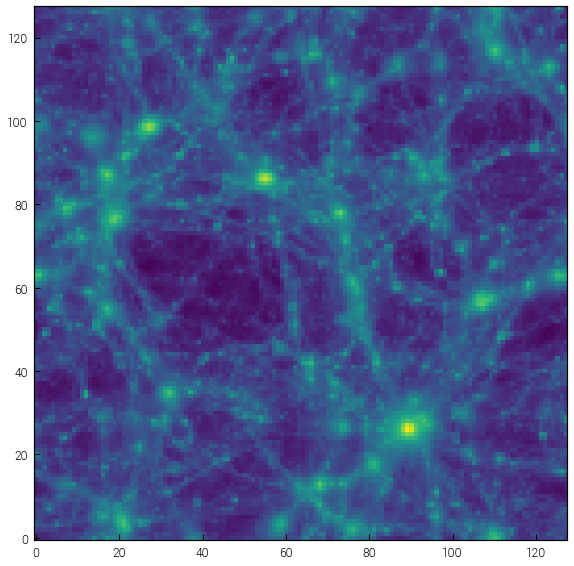

In [43]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(8,8))
plt.imshow(im2d,norm=LogNorm())
plt.show()

# [3] Scaling up: handling a large simulation

Until now, we have applied our framework to a very small simulation. 

However, what if we are working with a very large simulation (like TNG50-1, with $8^3 = 512$ times more particles/cells)?

## Starting simple: computing in chunks

First, we can still run the same calculation as above, and it will "just work" (hopefully).

This is because Dask has many versions of common algorithms and functions which work on "blocks" or "chunks" of the data, which split up the large array into smaller arrays. Work is needed on each chunk, after which the final answer is assembled.

Importantly, in our case above, even if the `mass` array above does not fit into memory, the `mass.sum().compute()` will chunk the operation up in a way that the task can be calculated.

In [2]:
snap_large = ArepoSnapshot(path.replace('TNG50-4','TNG50-2'))

In [3]:
snap_large.header["NumPart_Total"]

array([1135135195, 1259712000,          0, 1259712000,  103599364,
             3955], dtype=uint32)

Before we start, let's enable a progress indicator from dask:

In [4]:
from dask.diagnostics import ProgressBar
ProgressBar().register()

And then we can request the actual computation:

In [5]:
snap_large.data["PartType0"]["Masses"].sum().compute()

[########################################] | 100% Completed |  1min 26.1s


54559.98

While the result is eventually computed, it is a bit slow, primarily because the actual reading of the data off disk is the limiting factor, and this is happening in serial.

## More advanced: computing in parallel

Rather than sequentially calculating large tasks, we can also run the computation in parallel. 

To do so different advanced dask schedulers are available. Here, we use the most straight forward [distributed scheduler](https://docs.dask.org/en/latest/how-to/deploy-dask/single-distributed.html).

Usually, we would start a scheduler and then connect new workers (e.g. running on multiple compute/backend nodes of a HPC cluster). After, tasks (either interactively or scripted) can leverage the power of these connected resources.

For this example, we will use the same "distributed" scheduler/API, but keep things simple by using just the one (local) node we are currently running on.

In [10]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,threads_per_worker=1)
client = Client(cluster)

In [11]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 377.30 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40083,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 377.30 GiB
Comm: tcp://127.0.0.1:35469,Total threads: 1
Dashboard: http://127.0.0.1:43299/status,Memory: 94.33 GiB
Nanny: tcp://127.0.0.1:38931,


We can now perform the same operations, but it is performed in a distributed manner, in parallel.

One significant advantage is that (even when using only a single node) individual workers will load just the subsets of data they need to work on, meaing that I/O operations become parallel.

Note: after creating a `Client()`, all calls to `.compute()` will automatically use this new set of workers.

In [15]:
task = snap_large.data["PartType0"]["Masses"].sum()
task.compute()

54559.98

We can also view the progress of this task as it executes. For the distributed scheduler, a status dashboard exists (as a webpage).

You can find it by clicking on the "Dashboard" link above. If running this notebook server remotely, e.g. on a login node of a HPC cluster, you may have to change the '127.0.0.1' part of the address to be the same machine name/IP.

# [4] Units
For Arepo simulations, units via 'astropy.units' are available by default. These are hardcoded from the public AREPO and Illustris TNG documentation. Arrays will hold the units upon evalation. 

In [1]:
from darepo.interfaces.arepo import ArepoSnapshotWithUnits

In [5]:
snap = ArepoSnapshotWithUnits(path)

In [13]:
snap.data["PartType0"]["Masses"].sum().compute()

<Quantity 64600188. solMass>

# [5] Custom Functions

(beyond simple statistics/build-in numpy methods)

# [6] Derived Snapshot Fields
We can easily add recipes for new fields. For this, we need to define a new function
```
def field(arrs, **kwargs):
    newarr = ...arrs['key']...
    return newarr
```

where 'arrs' is a dictionary holding the keys available for the given data type (e.g. gas) and can be used to deduce new fields. The new function is to be decorated by 

```
@snap.register_field(parttype, name="fieldname")
def field(arrs, **kwargs):
    ...
```

if no name is given, the function name will be used for it. See an example below.

In [1]:
from darepo.interface import ArepoSnapshot
path = "/data/cbyrohl/TNGdata/TNG50-4/output/snapdir_099/"
snap = ArepoSnapshot(path)

In [16]:
import astropy.units as u
import astropy.constants as const

@snap.register_field("gas")
def Temperature(arrs, **kwargs):
    xh = 0.76
    eabu = (arrs['ElectronAbundance'],1.0)
    eint = (arrs['InternalEnergy'],(u.km/u.s)**2)
    mu = 4.0 / (1.0 + 3 * xh + 4 * xh * eabu[0])
    mu_unit = 1.0 /eabu[1] * const.m_p
    gamma = 5.0 / 3.0
    temp = ((gamma - 1.0) * eint[0] * mu)
    temp_unit = (mu_unit * eint[1] /const.k_B).to(u.K)
    return (temp*temp_unit).value

In [17]:
temp = snap.data["PartType0"]["Temperature"]
temp.mean().compute()

# [7] Next Steps

(what the caching warning means, how to use some caching)

(some links to docs of relevance etc)